# In Depth: Linear Regression


Linear regression models are a good starting point for regression tasks.
Such models are popular because they can be fit very quickly, and are very interpretable.
You are probably familiar with the simplest form of a linear regression model (i.e., fitting a straight line to data) but such models can be extended to model more complicated data behavior.

In this section we will start with a quick intuitive walk-through of the mathematics behind this well-known problem, before seeing how before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()


## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form

$$
y = ax + b
$$

where $a$ is commonly known as the _slope_, and $b$ is commonly known as the _intercept_.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of -5:


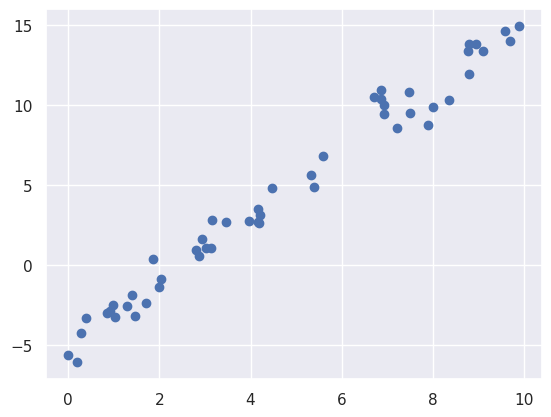

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y)


We can use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line:


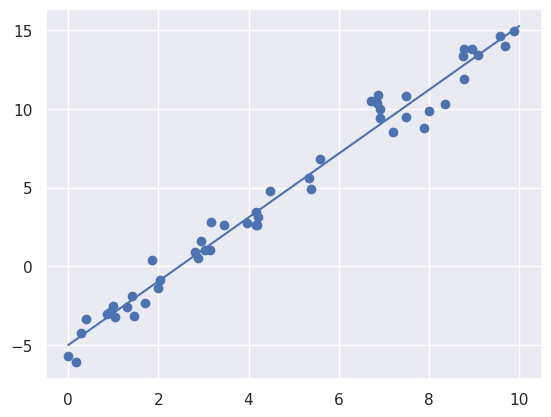

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)


The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are `coef_` and `intercept_`:


In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)


Model slope:     2.027208810360696
Model intercept: -4.9985770855532055


We see that the results are very close to the inputs, as we might hope.


The `LinearRegression` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form

$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$

where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyper-plane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)


0.500000000000002
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single `LinearRegression` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.


## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to _basis functions_.
We have seen one version of this before, in the `PolynomialRegression` pipeline.

The idea is to take our multidimensional linear model:
$$ y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots $$
and build the $x_1, x_2, x_3,$ and so on, from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

Notice that this is _still a linear model_—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.


### Polynomial basis functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:


In [41]:
from sklearn.preprocessing import PolynomialFeatures
# PolynomialFeatures?


In [42]:
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])


array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:


In [43]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())


With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$.
For example, here is a sine wave with noise:


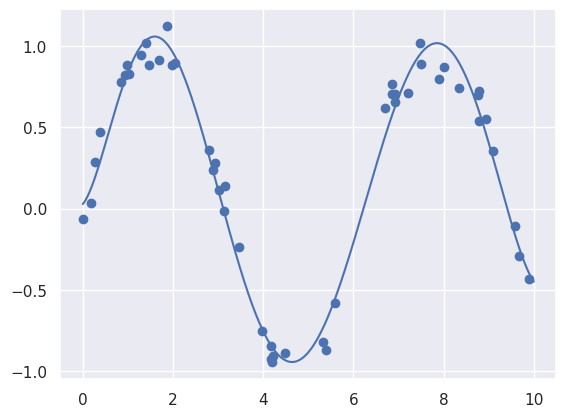

In [44]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)


Our linear model, through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data!


### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases.


The Gaussian basis function model can be helpful:

(1) Each basis function is non-zero over a very small interval and is zero everywhere else.

(2) These local basis functions result in a very sparse design matrix (i.e. one with mostly zeros) that leads to much faster computation.


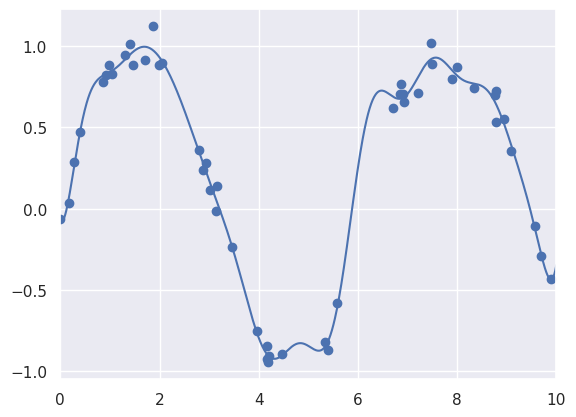

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin


class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""

    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor

    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))

    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self

    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)


gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10)


We put this example here just to make clear that there is nothing magic about polynomial basis functions: if you have some sort of intuition into the generating process of your data that makes you think one basis or another might be appropriate, you can use them as well.


## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to over-fitting.
For example, if we choose too many Gaussian basis functions, we end up with results that don't look so good:


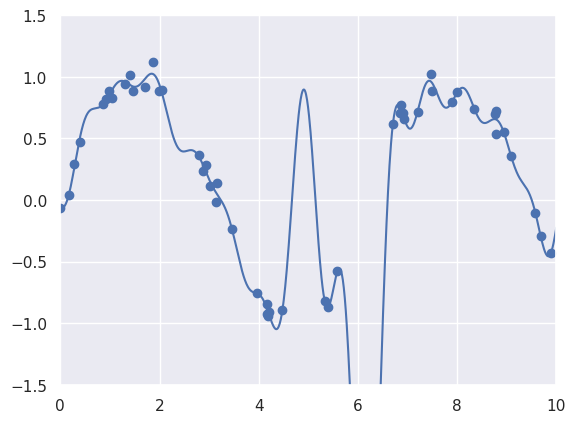

In [46]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5)


With the data projected to the 30-dimensional basis, the model has far too much flexibility and goes to extreme values between locations where it is constrained by data.
We can see the reason for this if we plot the coefficients of the Gaussian bases with respect to their locations:


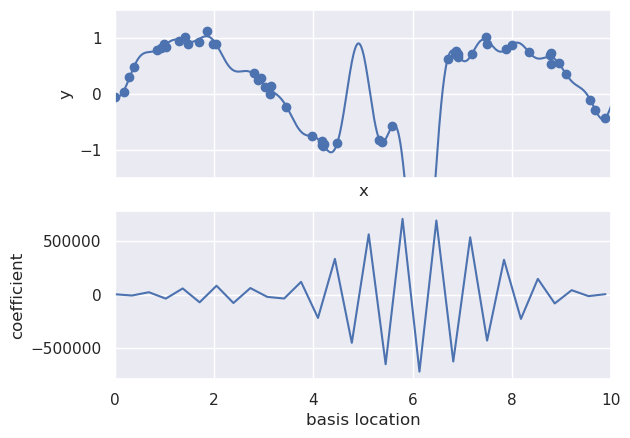

In [47]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))

    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))


model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)


The lower panel of this figure shows the amplitude of the basis function at each location.
This is typical over-fitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes expliticly in the model by penalizing large values of the model parameters.
Such a penalty is known as _regularization_, and comes in several forms.


### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as _ridge regression_ or $L_2$ _regularization_.
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the `Ridge` estimator:


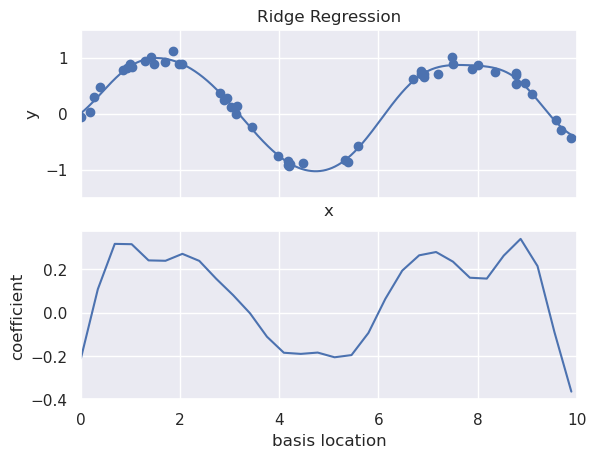

In [48]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')


The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.


### Lasso regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor _sparse models_ where possible: that is, it preferentially sets model coefficients to exactly zero.

We can see this behavior in duplicating the ridge regression figure, but using L1-normalized coefficients:


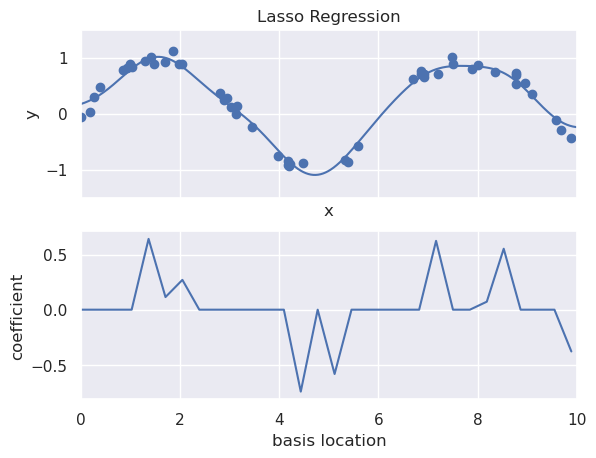

In [49]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.005))
basis_plot(model, title='Lasso Regression')


With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation.


# In Depth: Principal Component Analysis


Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analysis (PCA).
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.
After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications.

We begin with the standard imports:


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set()


## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data.
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:


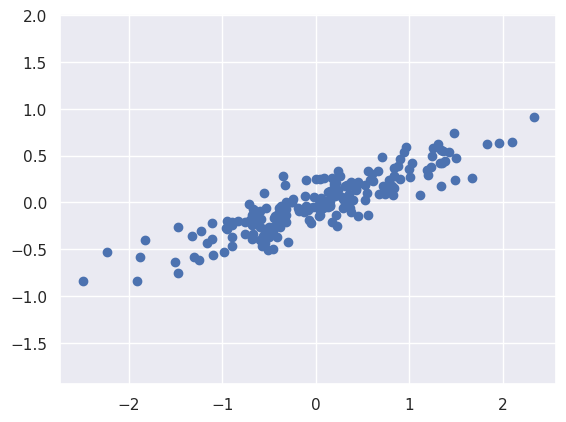

In [51]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')


By eye, it is clear that there is a nearly linear relationship between the x and y variables.
This is reminiscent of the linear regression data we explored in Linear Regression, but the problem setting here is slightly different: rather than attempting to _predict_ the y values from the x values, the unsupervised learning problem attempts to learn about the _relationship_ between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the _principal axes_ in the data, and using those axes to describe the dataset.
Using Scikit-Learn's `PCA` estimator, we can compute this as follows:


In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)


PCA(n_components=2)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":


In [53]:
print(pca.components_)


[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [54]:
print(pca.explained_variance_)


[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the input data, using the "components" to define the direction of the vector, and the "explained variance" to define the squared-length of the vector:


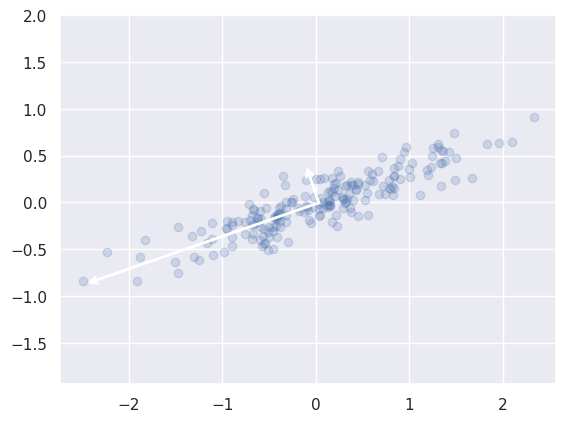

In [55]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops = dict(arrowstyle='->',
                      linewidth=2,
                      shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)


# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')


These vectors represent the _principal axes_ of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.


### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:


In [56]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)


original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:


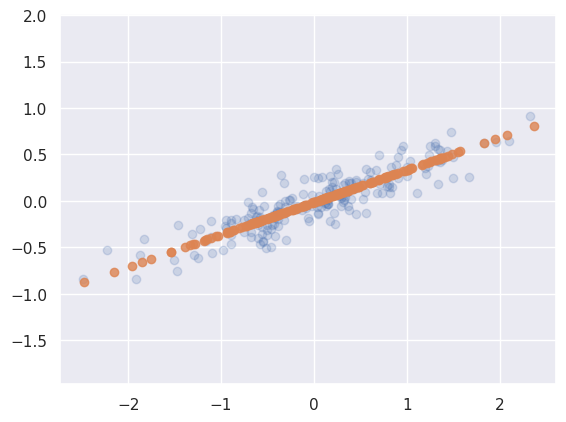

In [57]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal')


The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.


### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data.

We start by loading the data:


In [58]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape


(1797, 64)

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:


In [59]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)


(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:


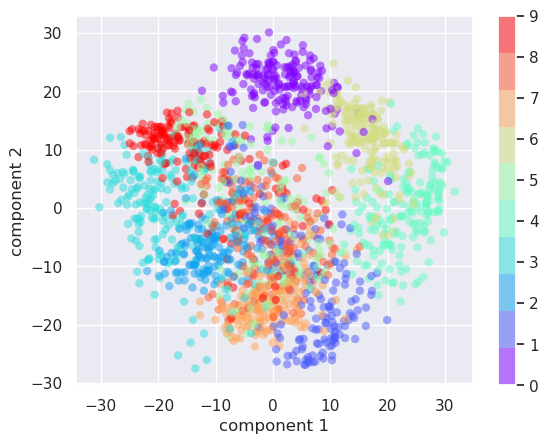

In [60]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()


Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.


### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative _explained variance ratio_ as a function of the number of components:


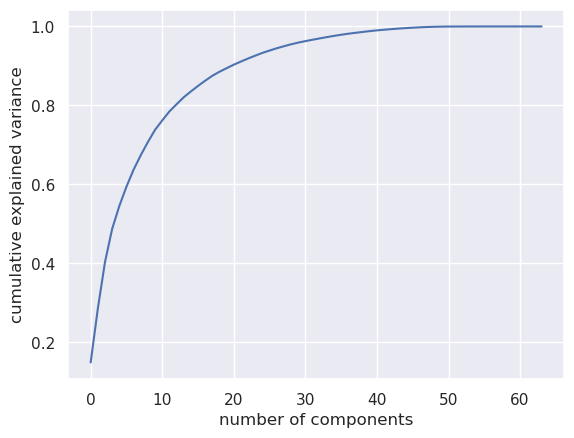

In [61]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance. Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.


## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:


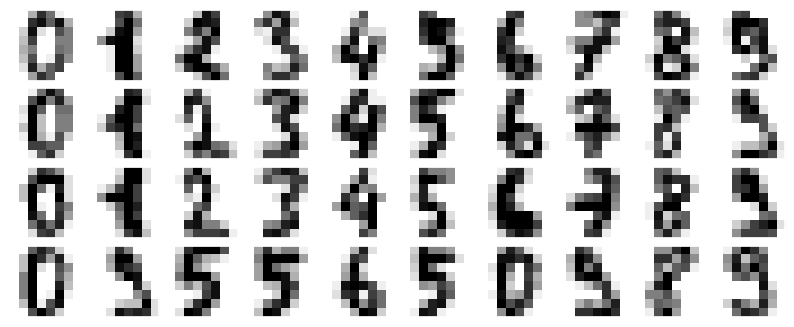

In [62]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))


plot_digits(digits.data)


Now lets add some random noise to create a noisy dataset, and re-plot it:


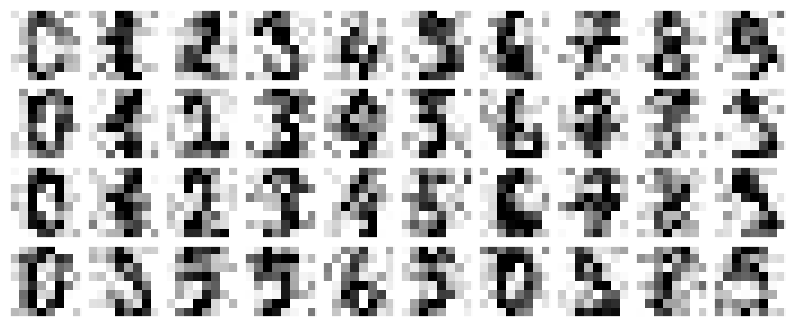

In [63]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)


It's clear by eye that the images are noisy, and contain spurious pixels.
Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:


In [64]:
pca = PCA(0.50).fit(noisy)
pca.n_components_


12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:


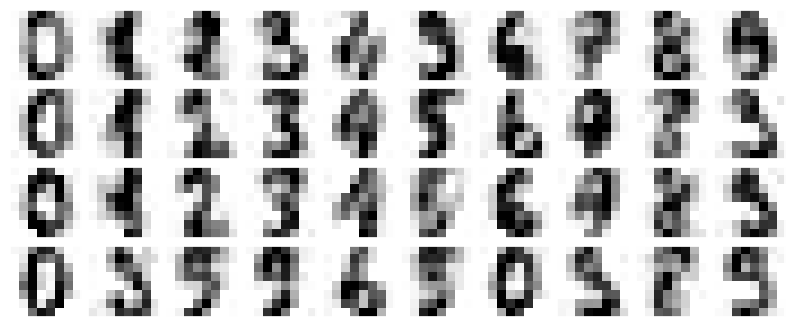

In [65]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)


This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.


# In Depth: k-Means Clustering


In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as _k-means clustering_, which is implemented in `sklearn.cluster.KMeans`.

We begin with the standard imports:


In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()  # for plot styling


## Introducing K-Means


The _k_-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

-   The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
-   Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the _k_-means model.
We will soon dive into exactly _how_ the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the _k_-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization


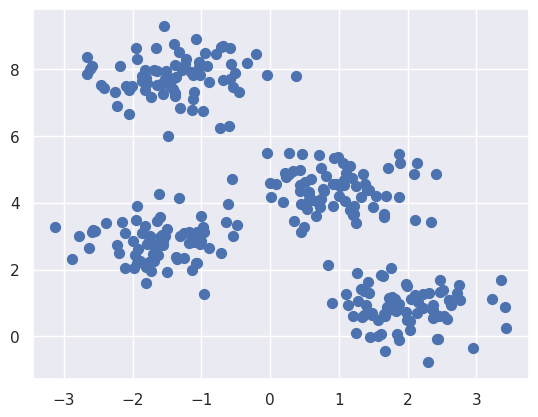

In [67]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)


By eye, it is relatively easy to pick out the four clusters.
The _k_-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:


In [68]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the _k_-means estimator:


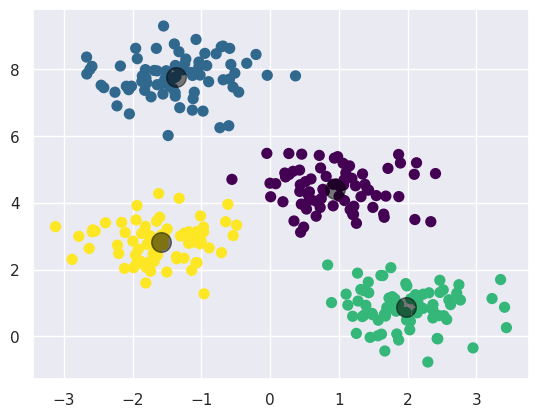

In [69]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


The good news is that the _k_-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to _k_-means involves an intuitive iterative approach known as _expectation–maximization_.


## k-Means Algorithm: Expectation–Maximization


Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
_k_-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
    1. _E-Step_: assign points to the nearest cluster center
    2. _M-Step_: set the cluster centers to the mean

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.


The _k_-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:


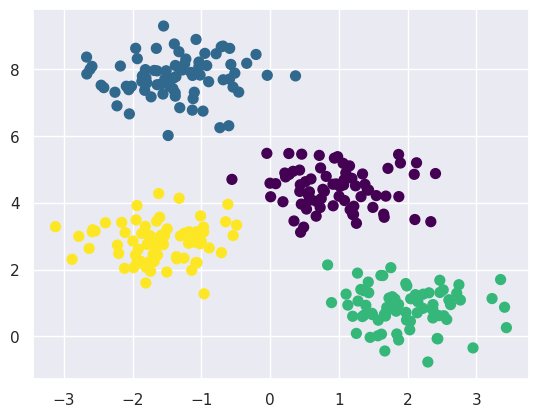

In [70]:
from sklearn.metrics import pairwise_distances_argmin


def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels


centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.


### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.


#### The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the _global_ best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:


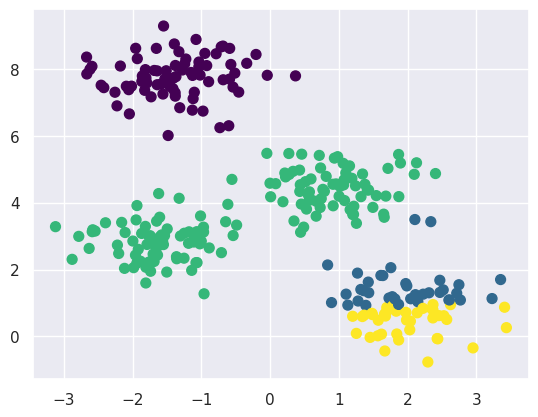

In [71]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the `n_init` parameter, which defaults to 10).


#### The number of clusters must be selected beforehand

Another common challenge with _k_-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:


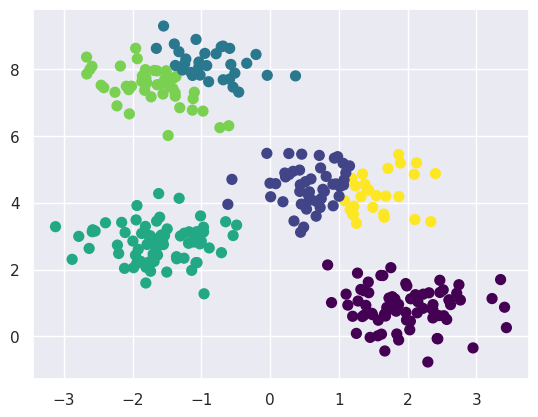

In [72]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models).


#### k-means is limited to linear cluster boundaries

The fundamental model assumptions of _k_-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between _k_-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical _k_-means approach:


In [73]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)


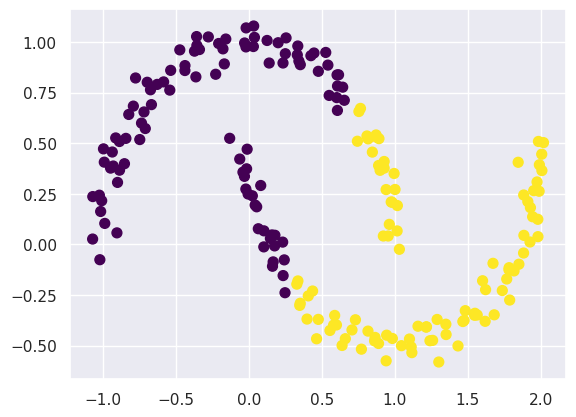

In [74]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


This situation is reminiscent of the discussion about support vector machine, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow _k_-means to discover non-linear boundaries.

One version of this kernelized _k_-means is implemented in Scikit-Learn within the `SpectralClustering` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a _k_-means algorithm:


/home/alex/anaconda3/envs/2001/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


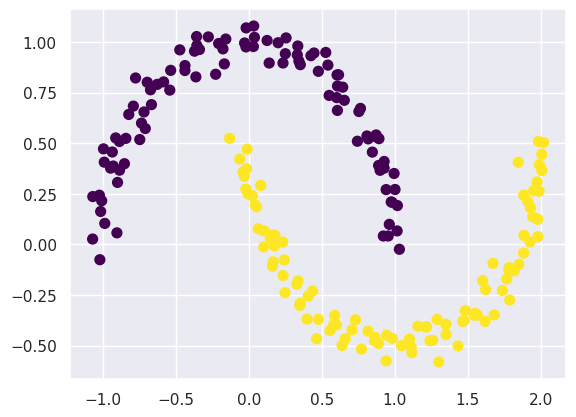

In [75]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


We see that with this kernel transform approach, the kernelized _k_-means is able to find the more complicated nonlinear boundaries between clusters.


#### k-means can be slow for large numbers of samples

Because each iteration of _k_-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based _k_-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard `KMeans`.
